this code is about the classification of the chest CT images into one of the four cancerous conditions namely adenocarcinoma, large cell carcinoma, squamous cell carcinoma and normal.

In [8]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB7
# from google.colab import drive
# drive.mount('/content/gdrive')
import scipy
print('done')

done


In [9]:
path = '.'
img_size = 224
print(img_size)

224


In [10]:
# !unzip Data.zip
!ls

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
B7_layeredLearningRate.ipynb  examples
B7run0			      nvidia-acknowledgements
Data			      plots
Data.zip		      plots1
LICENSE			      run1B7_layeredLearningRate.ipynb
Nvidia_Cloud_EULA.pdf	      src
README			      tools
__MACOSX		      tutorials
anaconda3


In [11]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
val_datagen= image.ImageDataGenerator()
test_datagen= image.ImageDataGenerator()

In [12]:
train_generator = train_datagen.flow_from_directory(
    f'{path}/Data/train',
    target_size = (img_size,img_size),
    batch_size = 16,
    shuffle=True,
    class_mode = 'categorical')
    
validation_generator = val_datagen.flow_from_directory(
    f'{path}/Data/valid',
    target_size = (img_size,img_size),
    batch_size = 1,
    shuffle=True,
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    f'{path}/Data/test',
    target_size = (img_size,img_size),
    batch_size = 1,
    shuffle=True,
    class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


I have developed a transfer learning based EfficientNetB3 model that has been trained on imagenet dataset. I have added some additional layers to the basic model.

In [16]:
#base_model = EfficientNetB7(weights='imagenet', classifier_activation="softmax", include_top=False)
base_model = EfficientNetB7(input_shape=(224,224,3), weights='imagenet', classifier_activation="softmax", include_top=False)

print(len(base_model.layers))
# print("Layers:", base_model.layers)
lr = 0.1
lr_mult = 0.9

parameters = []

i = 0
for layer in base_model.layers:
    layer.trainable=True

model = Sequential()
model.add(base_model)

# ADD A BATCH NORMALIZATION LAYER
model.add(BatchNormalization(name="top_batch_norm"))

model.add(GlobalMaxPooling2D(name="top_avg_pool"))
model.add(Dense(4, activation='softmax'))
model.summary()


#model.compile(loss='categorical_crossentropy',
              #optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              #metrics=['accuracy','AUC','Precision','Recall'])
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)
optimizers = [tf.keras.optimizers.Adam(learning_rate = lr_schedule), tf.keras.optimizers.Adam(learning_rate = 0.0001)]
optimizers_and_layers = [(optimizers[0], model.layers[0]), (optimizers[1], model.layers[1:])]

model.compile(loss='categorical_crossentropy',
              optimizer=tfa.optimizers.MultiOptimizer(optimizers_and_layers),
              metrics=['accuracy','AUC','Precision','Recall'])
              
#model.compile(loss='categorical_crossentropy',
              #optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              #metrics=['accuracy','AUC','Precision','Recall'])

813
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 top_batch_norm (BatchNormal  (None, 7, 7, 2560)       10240     
 ization)                                                        
                                                                 
 top_avg_pool (GlobalMaxPool  (None, 2560)             0         
 ing2D)                                                          
                                                                 
 dense (Dense)               (None, 4)                 10244     
                                                                 
Total params: 64,118,171
Trainable params: 63,802,324
Non-trainable params: 315,847
_________________________________________________________________


In [17]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                     

In [18]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
)

Epoch 1/30
39/39 [==============================] - 118s 1s/step - loss: 1.9500 - accuracy: 0.5318 - auc: 0.7611 - precision: 0.5453 - recall: 0.5204 - val_loss: 1.7027 - val_accuracy: 0.3611 - val_auc: 0.6774 - val_precision: 0.3594 - val_recall: 0.3194
Epoch 2/30
39/39 [==============================] - 37s 958ms/step - loss: 0.9159 - accuracy: 0.7325 - auc: 0.9094 - precision: 0.7479 - recall: 0.7113 - val_loss: 1.4969 - val_accuracy: 0.5000 - val_auc: 0.7693 - val_precision: 0.5217 - val_recall: 0.5000
Epoch 3/30
39/39 [==============================] - 39s 986ms/step - loss: 0.7944 - accuracy: 0.7879 - auc: 0.9338 - precision: 0.7930 - recall: 0.7814 - val_loss: 1.0952 - val_accuracy: 0.5833 - val_auc: 0.8507 - val_precision: 0.5781 - val_recall: 0.5139
Epoch 4/30
39/39 [==============================] - 39s 989ms/step - loss: 0.5410 - accuracy: 0.8189 - auc: 0.9620 - precision: 0.8306 - recall: 0.8157 - val_loss: 1.3386 - val_accuracy: 0.6250 - val_auc: 0.8254 - val_precision: 0.

In [19]:
print(history.history.keys())
h = history.history
print(h['val_accuracy'])

dict_keys(['loss', 'accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall'])
[0.3611111044883728, 0.5, 0.5833333134651184, 0.625, 0.6388888955116272, 0.625, 0.6944444179534912, 0.6527777910232544, 0.625, 0.6388888955116272, 0.6666666865348816, 0.6527777910232544, 0.6666666865348816, 0.7083333134651184, 0.7083333134651184, 0.7777777910232544, 0.7916666865348816, 0.8333333134651184, 0.8055555820465088, 0.8472222089767456, 0.8611111044883728, 0.8472222089767456, 0.8611111044883728, 0.8888888955116272, 0.8888888955116272, 0.875, 0.8611111044883728, 0.8611111044883728, 0.8055555820465088, 0.8472222089767456]


['loss', 'accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall']
loss loss val_loss


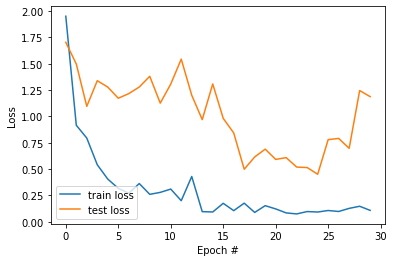

accuracy accuracy val_accuracy


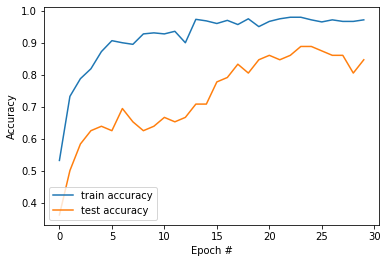

precision auc val_auc


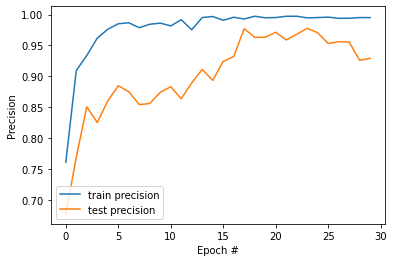

recall recall val_recall


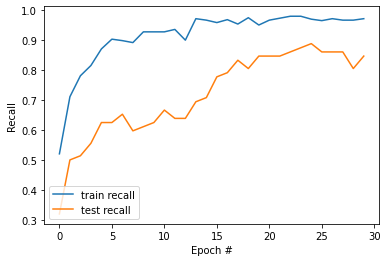

<Figure size 432x288 with 0 Axes>

In [20]:
hdict = history.history
keys = list(hdict.keys())
print(keys)
def graph(name, index):
    print(name, keys[index], keys[(len(keys) // 2) + index])
    train_metric, test_metric = hdict[keys[index]], hdict[keys[(len(keys) // 2) + index]]
    epochs = len(train_metric)
    x = list(range(epochs))

    plt.plot(x, train_metric, label=f'train {name}')
    plt.plot(x, test_metric, label=f'test {name}')

    plt.xlabel('Epoch #')
    plt.ylabel(name.capitalize())
    plt.legend(loc='lower left')
    plt.savefig(f'./plots1/{name}.png')
    plt.show()
    plt.clf()

graph('loss', 0)
graph('accuracy', 1)
graph('precision', 2)
graph('recall', 4)

In [21]:
model.evaluate(train_generator)

39/39 [==============================] - 8s 190ms/step - loss: 0.0326 - accuracy: 0.9918 - auc: 0.9978 - precision: 0.9918 - recall: 0.9918


[0.03261435404419899,
 0.9918434023857117,
 0.9977672696113586,
 0.9918434023857117,
 0.9918434023857117]

In [22]:
model.evaluate(validation_generator)


72/72 [==============================] - 3s 42ms/step - loss: 1.1873 - accuracy: 0.8472 - auc: 0.9292 - precision: 0.8472 - recall: 0.8472


[1.187320351600647,
 0.8472222089767456,
 0.929237425327301,
 0.8472222089767456,
 0.8472222089767456]

In [23]:
model.evaluate(test_generator)
# loss, 'accuracy','AUC','Precision','Recall'

315/315 [==============================] - 13s 42ms/step - loss: 0.5560 - accuracy: 0.9206 - auc: 0.9731 - precision: 0.9236 - recall: 0.9206


[0.5560399889945984,
 0.920634925365448,
 0.9731318354606628,
 0.9235668778419495,
 0.920634925365448]

In [24]:
tf.keras.models.save_model(model,'B7run1')

INFO:tensorflow:Assets written to: B7run1/assets


/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
